In [5]:
import pandas as pd
import os, pdb, copy
import numpy as np
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


In [13]:
def clean_time_series_data(df, cgm_cols=["Dexcom GL", "Libre GL"], activity_cols=["HR", "METs"]):
    """Clean and validate time-series data"""
    # Copy to avoid modifying original
    df = df.copy()
    
    # 1. Handle missing values
    for col in cgm_cols + activity_cols:
        if col in df.columns:
            # Linear interpolation with 5-minute window
            df[col] = df[col].interpolate(method='linear', limit=5)
            # Forward/backward fill remaining
            df[col] = df[col].ffill().bfill()
    
    return df

def load_daily_traces(
    dataset_df: pd.DataFrame,
    subject_id: int,
    cgm_cols=["Dexcom GL", "Libre GL"],
    activity_cols=["HR", "Calories (Activity)"],
    img_size=(112, 112),
    start_hour=6  # Start at 6 AM
):
    """
    Enhanced version with full-day (1440 minute) time features.
    """
    # Cleaning functions remain the same
    def clean_series(series):
        series = series.interpolate(method='linear', limit=5).ffill().bfill()
        try:
            from scipy.signal import savgol_filter
            series = savgol_filter(series, window_length=15, polyorder=2)
        except ImportError:
            series = series.rolling(window=15, min_periods=1, center=True).mean()
        return series

    # Apply cleaning
    cleaned_df = dataset_df.copy()
    for col in cgm_cols + activity_cols:
        if col in cleaned_df.columns:
            cleaned_df[col] = clean_series(cleaned_df[col])
    
    # Resample to 1-minute frequency
    resampled_df = cleaned_df.resample('1min').ffill(limit=5)
    
    # Fill NaNs with median
    for col in cgm_cols + activity_cols:
        if col in resampled_df.columns:
            resampled_df[col] = resampled_df[col].fillna(resampled_df[col].median())
    
    # Statistics for normalization
    cgm_stats = {
        'mean': resampled_df[cgm_cols].mean().values if all(col in resampled_df.columns for col in cgm_cols) else np.zeros(len(cgm_cols)),
        'std': resampled_df[cgm_cols].std().values if all(col in resampled_df.columns for col in cgm_cols) else np.ones(len(cgm_cols))
    }
    activity_stats = {
        'mean': resampled_df[activity_cols].mean().values if all(col in resampled_df.columns for col in activity_cols) else np.zeros(len(activity_cols)),
        'std': resampled_df[activity_cols].std().values if all(col in resampled_df.columns for col in activity_cols) else np.ones(len(activity_cols))
    }

    # Initialize arrays and dictionaries
    days = pd.Series(resampled_df.index.date).unique()
    days_list = [str(day) for day in days]
    cgm_daily_data = np.full((len(days), len(cgm_cols), 1440), np.nan)
    activity_daily_data = np.full((len(days), len(activity_cols), 1440), np.nan)
    image_data_by_day = {}
    nutrition_data_by_day = {}
    timestamp_vectors = {}  # Store full day timestamps
    meal_timing_features = {}  # Store meal timing features for full day
    
    # Time window parameters
    minutes_after_last_meal = 6 * 60  # 6 hours after last meal

    # Process each day
    for i, day in enumerate(days):
        day_start = pd.Timestamp(day)
        day_end = day_start + pd.Timedelta(days=1) - pd.Timedelta(minutes=1)
        day_data = resampled_df.loc[day_start:day_end]
        
        # Extract meal information for this day
        meal_rows = dataset_df.loc[day_start:day_end].dropna(subset=['Meal Type'])
        meal_times = meal_rows.index.sort_values() if not meal_rows.empty else []
        
        # Create full day timestamp vector (1440 minutes)
        full_day_timestamps = [day_start + pd.Timedelta(minutes=m) for m in range(1440)]
        timestamp_vectors[str(day)] = full_day_timestamps
        
        # Initialize full day meal timing features
        meal_timing = np.zeros((5, 1440))  # 5 features for 1440 minutes
        
        # Set default values for all minutes
        meal_timing[0, :] = -1  # Minutes since most recent meal
        meal_timing[1, :] = -1  # Minutes until next meal
        meal_timing[2, :] = 0   # Is within 2 hours after meal
        meal_timing[3, :] = 0   # Count of previous meals
        meal_timing[4, :] = np.arange(1440)  # Minutes since start of day
        
        # Determine time window for processing (we'll still store full day)
        if len(meal_times) == 0:
            # If no meals, use default window (6 AM to midnight)
            window_start = day_start + pd.Timedelta(hours=start_hour)
            window_end = day_end
        else:
            # Start at 6 AM
            window_start = day_start + pd.Timedelta(hours=start_hour)
            
            # End 6 hours after the last meal or at day end, whichever is earlier
            last_meal_time = meal_times[-1]
            last_meal_plus_6h = last_meal_time + pd.Timedelta(minutes=minutes_after_last_meal)
            window_end = min(last_meal_plus_6h, day_end)
        
        # Filter data to our window
        window_data = day_data.loc[window_start:window_end]
        
        # Calculate window minutes for validation/debugging
        window_minutes = len(window_data)
        
        if not window_data.empty:
            # Store CGM and activity data for the window
            for j, col in enumerate(cgm_cols):
                if col in window_data.columns:
                    # Get minutes of day for each window timestamp
                    minutes_of_day = (window_data.index.hour * 60 + window_data.index.minute).values
                    
                    vals = window_data[col].values
                    vals = np.nan_to_num(vals, nan=window_data[col].median())
                    cgm_daily_data[i, j, minutes_of_day] = vals
            
            for j, col in enumerate(activity_cols):
                if col in window_data.columns:
                    # Get minutes of day for each window timestamp
                    minutes_of_day = (window_data.index.hour * 60 + window_data.index.minute).values
                    
                    vals = window_data[col].values
                    vals = np.nan_to_num(vals, nan=window_data[col].median())
                    activity_daily_data[i, j, minutes_of_day] = vals
            
            # Calculate meal timing features for each timestamp in the full day
            for minute in range(1440):
                timestamp = day_start + pd.Timedelta(minutes=minute)
                
                # 1. Minutes since most recent meal
                prev_meals = [m for m in meal_times if m <= timestamp]
                if prev_meals:
                    meal_timing[0, minute] = (timestamp - prev_meals[-1]).total_seconds()/60
                # else keep default -1
                
                # 2. Minutes until next meal
                next_meals = [m for m in meal_times if m > timestamp]
                if next_meals:
                    meal_timing[1, minute] = (next_meals[0] - timestamp).total_seconds()/60
                # else keep default -1
                
                # 3. Boolean: Is this within 2 hours after a meal?
                meal_timing[2, minute] = 1 if (meal_timing[0, minute] >= 0 and meal_timing[0, minute] <= 120) else 0
                
                # 4. Count of previous meals for the day
                meal_timing[3, minute] = len(prev_meals)
                
                # 5. Minutes since start of day is already set to minute number
        
        # Store meal timing features (full day)
        meal_timing_features[str(day)] = meal_timing
        
        # Process nutrition data with more detailed information
        day_str = str(day)
        original_day_data = dataset_df.loc[day_start:day_end]
        
        nutrition_rows = original_day_data.dropna(subset=['Calories', 'Carbs', 'Protein', 'Fat', 'Fiber'], how='all')
        day_nutrition = []
        
        # Enhanced meal information
        meal_counter = {}  # Track meal numbers by type
        
        # Process meals in chronological order
        for ts, row in nutrition_rows.iterrows():
            meal_type = row['Meal Type'] if pd.notna(row['Meal Type']) else 'Unknown'
            
            # Increment meal counter for this type
            if meal_type not in meal_counter:
                meal_counter[meal_type] = 1
            else:
                meal_counter[meal_type] += 1
                
            # Calculate meal timing within day
            minutes_since_day_start = (ts - day_start).total_seconds() / 60
            hour_of_day = ts.hour + ts.minute/60
            
            nutrition = {
                'timestamp': ts.strftime('%Y-%m-%d %H:%M:%S'),
                'MealType': meal_type,
                'MealNumber': meal_counter[meal_type],  # Which breakfast/lunch/dinner/snack is this?
                'MinuteOfDay': int(minutes_since_day_start),
                'HourOfDay': hour_of_day,
                'calories': row['Calories'] if pd.notna(row['Calories']) else 0,
                'carbs': row['Carbs'] if pd.notna(row['Carbs']) else 0,
                'protein': row['Protein'] if pd.notna(row['Protein']) else 0,
                'fat': row['Fat'] if pd.notna(row['Fat']) else 0,
                'fiber': row['Fiber'] if pd.notna(row['Fiber']) else 0,
                'has_image': pd.notna(row['Image path'])
            }
            day_nutrition.append(nutrition)
        
        # Add meal sequence information
        if day_nutrition:
            # Sort by timestamp
            day_nutrition = sorted(day_nutrition, key=lambda x: x['MinuteOfDay'])
            
            # Add meal sequence number and intervals
            for k in range(len(day_nutrition)):
                day_nutrition[k]['MealSequence'] = k + 1  # 1-based meal sequence for the day
                
                # Time to next meal
                if k < len(day_nutrition) - 1:
                    day_nutrition[k]['MinutesToNextMeal'] = day_nutrition[k+1]['MinuteOfDay'] - day_nutrition[k]['MinuteOfDay']
                else:
                    day_nutrition[k]['MinutesToNextMeal'] = -1  # No next meal
                
                # Time since previous meal
                if k > 0:
                    day_nutrition[k]['MinutesSincePrevMeal'] = day_nutrition[k]['MinuteOfDay'] - day_nutrition[k-1]['MinuteOfDay']
                else:
                    day_nutrition[k]['MinutesSincePrevMeal'] = -1  # No previous meal
        
        nutrition_data_by_day[day_str] = day_nutrition
        
        # Image data processing remains largely the same
        image_rows = original_day_data.dropna(subset=['Image path'])
        day_images = []
        for ts, row in image_rows.iterrows():
            try:
                img_data = get_image(row['Image path'], subject_id, img_size)
                # Calculate timing features for this image/meal
                minutes_since_day_start = (ts - day_start).total_seconds() / 60
                
                metadata = {
                    'timestamp': ts.strftime('%Y-%m-%d %H:%M:%S'),
                    'minute_of_day': int(minutes_since_day_start),
                    'meal_type': row['Meal Type'] if 'Meal Type' in row else None,
                    'calories': row['Calories'] if 'Calories' in row else None,
                    'carbs': row['Carbs'] if 'Carbs' in row else None,
                    'protein': row['Protein'] if 'Protein' in row else None,
                    'fat': row['Fat'] if 'Fat' in row else None,
                    'fiber': row['Fiber'] if 'Fiber' in row else None
                }
                day_images.append({'image': img_data, 'metadata': metadata})
            except FileNotFoundError:
                continue
        image_data_by_day[day_str] = day_images if day_images else []

    # Window metadata
    window_metadata = {
        'start_hour': start_hour,
        'hours_after_last_meal': minutes_after_last_meal / 60,
        'full_day_length': 1440
    }

    return (
        days_list,
        cgm_daily_data,
        activity_daily_data,
        image_data_by_day,
        nutrition_data_by_day,
        cgm_stats,
        activity_stats,
        window_metadata,
        timestamp_vectors,        # Now: full day timestamps
        meal_timing_features      # Now: full day meal timing features
    )

In [14]:
def load_CGMacros(
    subject_id: int,
    csv_dir: str = "CGMacros 2",
) -> pd.DataFrame:
    if type(subject_id) != int:
        print("subject_id should be an integer")
        raise ValueError
    subejct_path = f"CGMacros-{subject_id:03d}/CGMacros-{subject_id:03d}.csv"
    subject_file = os.path.join(csv_dir, subejct_path)
    if not os.path.exists(subject_file):
        tqdm.write(f"File {subject_file} not found")
        raise FileNotFoundError
    dataset_df = pd.read_csv(subject_file, index_col=None)
    dataset_df["Timestamp"] = pd.to_datetime(dataset_df["Timestamp"])
    dataset_df = clean_time_series_data(dataset_df)  # Add cleaning step
    return dataset_df.set_index("Timestamp")

def get_image(
    img_filename: str,
    subject_id: int,
    target_size: tuple,
    cgmacros_path: str = "CGMacros 2/",
) -> np.ndarray:
    subject_path = f"CGMacros-{subject_id:03d}/"
    img_path = f"{cgmacros_path}{subject_path}{img_filename}"
    if not os.path.exists(img_path):
        print(f"File {img_path} not found")
        raise FileNotFoundError
    # Loading names out
    img_data = cv2.resize(
        cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB),
        target_size,
        interpolation=cv2.INTER_LANCZOS4,
    )
    return img_data
def create_daily_dataset(
    subject_id: int,
    csv_dir: str = "CGMacros 2",
    cgm_cols=["Dexcom GL", "Libre GL"],
    activity_cols=["HR"],
    img_size=(112, 112),
    start_hour=6,
    verbose=False
):
    try:
        # Load data with column validation
        dataset_df = load_CGMacros(subject_id, csv_dir)
        
        
        if verbose:
            print("Available columns:", dataset_df.columns.tolist())
        
        # Handle missing columns gracefully
        available_activity_cols = [col for col in activity_cols 
                                 if col in dataset_df.columns]
        if len(available_activity_cols) < len(activity_cols):
            print(f"Warning: Missing activity columns. Using {available_activity_cols} for subject {subject_id}")
        
        # Process data with validated columns and custom time window
        result = load_daily_traces(
            dataset_df, subject_id, 
            cgm_cols=cgm_cols,
            activity_cols=available_activity_cols,
            img_size=img_size,
            start_hour=start_hour
        )
        
        return (subject_id,) + result  # Return all elements with subject_id
    
    except FileNotFoundError:
        print(f"Data for subject {subject_id} not found.")
        return None
    except Exception as e:
        print(f"Error processing subject {subject_id}: {str(e)}")
        return None

In [38]:
def process_multiple_subjects(
    subject_ids=None,
    csv_dir="CGMacros 2",
    demographics_path = "demographicPCA.csv",
    save_dir="processed_data/",
    cgm_cols=["Dexcom GL","Libre GL"],
    activity_cols=["HR"],
    img_size=(112, 112),
    start_hour=6
):
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if subject_ids is None:
        subject_ids = range(1, 51)  # Try subjects 1-50
    
    summary = {
        'processed_subjects': [],
        'total_days': 0,
        'total_images': 0,
        'total_meals': 0
    }
    
    for subject_id in tqdm(subject_ids, desc="Processing subjects"):
        result = create_daily_dataset(subject_id, csv_dir, start_hour=start_hour)
        if result is None:
            continue
            
        # Unpack all return values
        (subject_id, days, cgm, activity, images, nutrition, 
         cgm_stats, activity_stats, window_metadata, 
         timestamp_vectors, meal_timing_features) = result
        
        pca_df = pd.read_csv(demographics_path)
        pca_vector = pca_df[pca_df['SubjectID'] == subject_id].iloc[0, 1:].values.astype("float32")

        
        # Save data with all new features
        subject_data = {
            'subject_id': subject_id,
            'days': days,
            'cgm_data': cgm,
            'activity_data': activity,
            'image_data': images,
            'nutrition_data': nutrition,
            'cgm_stats': cgm_stats,
            'activity_stats': activity_stats,
            'demographics':pca_vector,
            'window_metadata': window_metadata,
            'timestamp_vectors': timestamp_vectors,  # New: store timestamps
            'meal_timing_features': meal_timing_features  # New: meal timing features
        }
        torch.save(subject_data, os.path.join(save_dir, f"subject_{subject_id:03d}_daily_data.pt"))
        
        # Update summary counts
        summary['processed_subjects'].append(subject_id)
        summary['total_days'] += len(days)
        summary['total_images'] += sum(len(imgs) for imgs in images.values())
        summary['total_meals'] += sum(len(meals) for meals in nutrition.values())
    return summary

In [40]:
class DailyTracesDataset(Dataset):
    def __init__(self, data_dir, subject_ids=None, transform=None, skip_days=[1]):
        # Initialization remains the same
        self.data_dir = data_dir
        self.transform = transform
        self.skip_days = skip_days or [1]
        transform = None
        
        # Find relevant subject files
        if subject_ids is None:
            self.data_files = [
                f for f in os.listdir(data_dir) 
                if f.startswith("subject_") and f.endswith("_daily_data.pt")
            ]
        else:
            self.data_files = [
                f"subject_{sid:03d}_daily_data.pt" 
                for sid in subject_ids 
                if os.path.exists(os.path.join(data_dir, f"subject_{sid:03d}_daily_data.pt"))
            ]
        
        # Build indices accounting for skip_days
        self.indices = []
        self.subject_day_pairs = []
        
        for file_idx, fname in enumerate(self.data_files):
            data = torch.load(os.path.join(data_dir, fname), weights_only=False)
            subject_id = data['subject_id']
            
            for day_idx, day_str in enumerate(data['days']):
                day_num = int(day_str.split('-')[2])
                if day_num not in self.skip_days:
                    self.indices.append((file_idx, day_idx))
                    self.subject_day_pairs.append((subject_id, day_num))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        file_idx, day_idx = self.indices[idx]
        data = torch.load(os.path.join(self.data_dir, self.data_files[file_idx]), weights_only=False)
        day = data['days'][day_idx]
        
        # Apply transforms if specified
        def _apply_transform(x):
            return self.transform(x) if self.transform else x
        
        demographics_path = 'demographicPCA.csv'
        pca_df = pd.read_csv(demographics_path)
        # Include the new features in the returned item
        return {
            'subject_id': data['subject_id'],
            'day': day,
            'cgm_data': _apply_transform(data['cgm_data'][day_idx]),
            'demographics' : torch.tensor(
    pca_df[pca_df['SubjectID'] == data['subject_id']].iloc[0, 1:].values,
    dtype=torch.float32
),
            'activity_data': _apply_transform(data['activity_data'][day_idx]),
            'images': [_apply_transform(img['image']) for img in data['image_data'].get(day, [])],
            'nutrition': data['nutrition_data'].get(day, []),
            'subject_day_pair': self.subject_day_pairs[idx],
            'timestamps': data.get('timestamp_vectors', {}).get(day, []),  # New: timestamps
            'meal_timing_features': data.get('meal_timing_features', {}).get(day, [])  # New: meal timing features
        }

In [48]:
def custom_collate(batch):
    """Handles variable-length nutrition data, images and timestamp vectors"""
    import numpy as np

    def fix_nans(array):
        """Replace NaNs with median (per channel)"""
        median_vals = np.nanmedian(array, axis=1, keepdims=True)
        return np.where(np.isnan(array), median_vals, array)

    # Fix NaNs before converting to tensors
    for i, x in enumerate(batch):
        x['cgm_data'] = fix_nans(x['cgm_data'])
        x['activity_data'] = fix_nans(x['activity_data'])
        if 'meal_timing_features' in x and len(x['meal_timing_features']) > 0:
            x['meal_timing_features'] = fix_nans(x['meal_timing_features'])

    return {
        'subject_ids': torch.tensor([x['subject_id'] for x in batch]),
        'days': [x['day'] for x in batch],
        
        'cgm_data': torch.stack([torch.tensor(x['cgm_data'], dtype=torch.float32) for x in batch]),
        'activity_data': torch.stack([torch.tensor(x['activity_data'], dtype=torch.float32) for x in batch]),
        'images': [x['images'] for x in batch],  # List of lists
        'nutrition': [x['nutrition'] for x in batch],  # List of lists
        'subject_day_pairs': [x['subject_day_pair'] for x in batch],
        'timestamps': [x.get('timestamps', []) for x in batch],  # New: timestamps for each data point
        'meal_timing_features': [torch.tensor(x.get('meal_timing_features', np.zeros((5, 1))), 
                                              dtype=torch.float32) if len(x.get('meal_timing_features', [])) > 0 
                                 else torch.zeros((5, 1)) for x in batch],  # New: meal timing features,
        'demographics': torch.stack([x['demographics'] for x in batch])
    }

In [18]:
def split_dataset_by_subject_day(dataset, test_size=0.2, random_state=2025):
    """
    Split the dataset based on subject-day pairs to ensure all data from
    the same subject and day stays together in either training or testing set.
    
    Args:
        dataset (DailyTracesDataset): The dataset to split
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
    
    Returns:
        tuple: (train_indices, test_indices)
    """
    # Get unique subject-day pairs
    subject_day_df = pd.DataFrame(dataset.subject_day_pairs, columns=['subject_id', 'day_id'])
    unique_pairs = subject_day_df.drop_duplicates()
    
    # Split the unique subject-day pairs
    train_pairs, test_pairs = train_test_split(
        unique_pairs, 
        test_size=test_size,
        random_state=random_state
    )
    
    # Convert to sets for faster lookup
    train_pairs_set = set(zip(train_pairs['subject_id'], train_pairs['day_id']))
    test_pairs_set = set(zip(test_pairs['subject_id'], test_pairs['day_id']))
    
    # Create masks for train and test indices
    train_indices = []
    test_indices = []
    
    for i, (subject_id, day_id) in enumerate(dataset.subject_day_pairs):
        if (subject_id, day_id) in train_pairs_set:
            train_indices.append(i)
        elif (subject_id, day_id) in test_pairs_set:
            test_indices.append(i)
    
    return train_indices, test_indices


class SubjectDaySubset(Dataset):
    """
    Subset of DailyTracesDataset based on indices.
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]
def get_train_test_datasets(data_dir, subject_ids=None, test_size=0.2, random_state=2025, transform=None):
    """
    Get train and test datasets split by subject-day pairs.
    
    Args:
        data_dir (str): Directory containing processed data
        subject_ids (list): List of subject IDs to include. If None, include all available.
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        transform (callable): Optional transform to apply to the data
    
    Returns:
        tuple: (train_dataset, test_dataset)
    """
    # Create the full dataset
    full_dataset = DailyTracesDataset(data_dir, subject_ids, transform)
    
    # Split by subject-day pairs
    train_indices, test_indices = split_dataset_by_subject_day(full_dataset, test_size, random_state)
    
    # Create train and test subsets
    train_dataset = SubjectDaySubset(full_dataset, train_indices)
    test_dataset = SubjectDaySubset(full_dataset, test_indices)
    
    print(f"Full dataset size: {len(full_dataset)}")
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    return train_dataset, test_dataset

In [41]:
from torch.utils.data import DataLoader

def main():
    # Step 1: Process the raw CSV data for subjects and save the daily traces
    # You can adjust the subject IDs, directories, etc. as needed
    summary = process_multiple_subjects(
        subject_ids=range(1, 50),  # Process subjects 1-49
        csv_dir="CGMacros 2",  # Path to your CSV files
        save_dir="processed_data/",  # Where to save processed data
        cgm_cols=["Dexcom GL", "Libre GL"],
        activity_cols=["HR"],
        img_size=(112, 112),
        start_hour=6  # New parameter: starting hour (6 AM)
    )
    
    print(f"Processing summary:")
    print(f"- Processed {len(summary['processed_subjects'])} subjects")
    print(f"- Total days: {summary['total_days']}")
    print(f"- Total images: {summary['total_images']}")
    print(f"- Total meals: {summary['total_meals']}")  # Added meal count
    
    # Step 2: Create train and test datasets from the processed data
    train_dataset, test_dataset = get_train_test_datasets(
        data_dir="processed_data/",
        subject_ids=None,  # Use all available subjects
        test_size=0.2,  # 80% train, 20% test
        random_state=2025,  # For reproducibility
        transform=None  # Add any transforms you need
    )
    
    print("Done creating train and test datasets")
    


    #Step 3: Create DataLoaders for efficient batching
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=0,
        collate_fn=custom_collate
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=custom_collate
    )
    
    return train_loader, test_loader

In [20]:
train_loader, test_loader = main()

Processing subjects:   0%|          | 0/49 [00:00<?, ?it/s]

File CGMacros 2/CGMacros-001/photos/00000075-PHOTO-2020-5-9-9-48-0.jpg not found


Processing subjects:   2%|▏         | 1/49 [00:03<02:49,  3.52s/it]

File CGMacros 2/CGMacros-002/photos/00000082-PHOTO-2019-11-24-11-37-0.jpg not found
File CGMacros 2/CGMacros-002/photos/00000083-PHOTO-2019-11-24-12-13-0.jpg not found


Processing subjects:  47%|████▋     | 23/49 [01:01<01:14,  2.86s/it]

File CGMacros 2/CGMacros-024/CGMacros-024.csv not found
Data for subject 24 not found.
File CGMacros 2/CGMacros-025/CGMacros-025.csv not found
Data for subject 25 not found.


Processing subjects:  73%|███████▎  | 36/49 [01:27<00:32,  2.46s/it]

File CGMacros 2/CGMacros-037/CGMacros-037.csv not found
Data for subject 37 not found.


Processing subjects:  80%|███████▉  | 39/49 [01:32<00:19,  1.96s/it]

File CGMacros 2/CGMacros-040/CGMacros-040.csv not found
Data for subject 40 not found.


Processing subjects: 100%|██████████| 49/49 [01:55<00:00,  2.36s/it]


Processing summary:
- Processed 45 subjects
- Total days: 533
- Total images: 3194
- Total meals: 1706
Full dataset size: 512
Train dataset size: 409
Test dataset size: 103
Done creating train and test datasets


In [21]:


def compute_calorie_stats(data_loader):
    """
    Computes the mean and std of daily total calories across the dataset.
    
    Each batch is a dict with 'nutrition' key, which contains a list of days,
    where each day is a list of meal dicts.
    """
    total_calories_per_day = []

    for batch in data_loader:
        for day_meals in batch["nutrition"]:  # each element is a day's meals
            if isinstance(day_meals, list):
                day_total = sum(meal.get("calories", 0) for meal in day_meals if isinstance(meal, dict))
                if day_total > 800:
                    total_calories_per_day.append(day_total)

    calories_tensor = torch.tensor(total_calories_per_day, dtype=torch.float32)
    return calories_tensor.mean().item(), calories_tensor.std().item()


In [22]:
global_mean, global_std = compute_calorie_stats(train_loader)
global_mean, global_std = float(global_mean), float(global_std)
global_std

/home/grads/a/atkulkarni/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1233: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


630.0023803710938

In [23]:
global_mean

1843.1124267578125

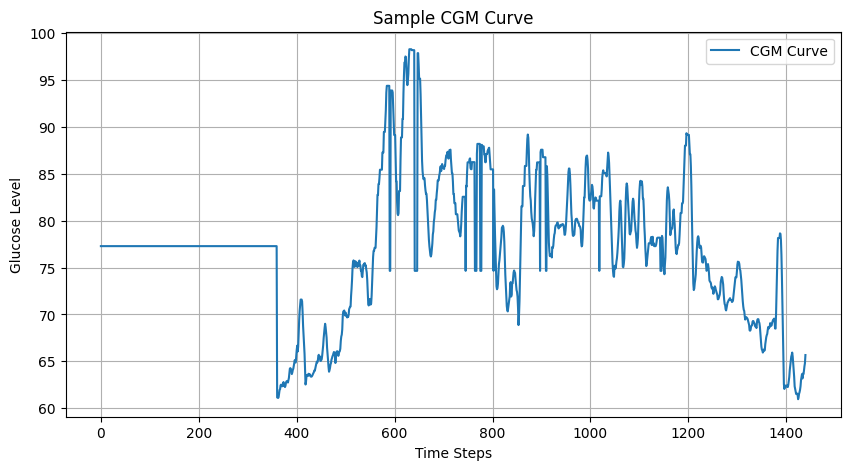

In [67]:
eg = batch['activity_data'][0][0]

plt.figure(figsize=(10, 5))
plt.plot(eg, label="CGM Curve")
plt.xlabel("Time Steps")
plt.ylabel("Glucose Level")
plt.title("Sample CGM Curve")
plt.grid(True)
plt.legend()
plt.show()   

In [83]:
batch['nutrition'][0]

[{'timestamp': '2019-11-23 09:59:00',
  'MealType': 'Breakfast',
  'MealNumber': 1,
  'MinuteOfDay': 599,
  'HourOfDay': 9.983333333333333,
  'calories': 712.0,
  'carbs': 66.0,
  'protein': 22.0,
  'fat': 42.0,
  'fiber': 0.0,
  'has_image': True,
  'MealSequence': 1,
  'MinutesToNextMeal': 271,
  'MinutesSincePrevMeal': -1},
 {'timestamp': '2019-11-23 14:30:00',
  'MealType': 'Lunch',
  'MealNumber': 1,
  'MinuteOfDay': 870,
  'HourOfDay': 14.5,
  'calories': 445.0,
  'carbs': 43.0,
  'protein': 20.0,
  'fat': 20.0,
  'fiber': 13.0,
  'has_image': True,
  'MealSequence': 2,
  'MinutesToNextMeal': 291,
  'MinutesSincePrevMeal': 271},
 {'timestamp': '2019-11-23 19:21:00',
  'MealType': 'Dinner',
  'MealNumber': 1,
  'MinuteOfDay': 1161,
  'HourOfDay': 19.35,
  'calories': 291.0,
  'carbs': 33.0,
  'protein': 6.0,
  'fat': 14.0,
  'fiber': 1.0,
  'has_image': True,
  'MealSequence': 3,
  'MinutesToNextMeal': -1,
  'MinutesSincePrevMeal': 291}]

In [24]:
def process_labels(labels,mean,std, device, dtype=torch.float32):
    """
    Processes labels by summing the 'calories' field for each instance in a batch.

    Args:
        labels (list of list of dicts): A batch of labels, where each instance is a list of meal records.
        device (str): Target device ("cuda:0" or "cpu").
        dtype (torch.dtype): Data type (default: float16 for mixed precision).

    Returns:
        torch.Tensor: Tensor of shape (batch_size,) with summed calories per instance.
    """
    batch_calories = [
        sum(entry.get("calories", 0) for entry in instance)  
        for instance in labels
    ]
    labels_tensor = torch.tensor(batch_calories, dtype=dtype).to(device)
    normalized_labels = (labels_tensor - mean) / (std + 1e-8)
    
    return normalized_labels



In [25]:
import torch
import torch.nn as nn  # Import torch.nn
import torch.nn.functional as F 
class RMSRELoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon  # Small value to avoid division by zero
    
    def forward(self, pred, target):
        relative_error = (pred - target) / (target + self.epsilon)
        squared_rel_error = relative_error ** 2
        mean_squared_rel_error = torch.mean(squared_rel_error)
        return torch.sqrt(mean_squared_rel_error)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(
    activity_encoder, 
    cgm_encoder,
    meal_timing_encoder,  # New encoder for meal timing features
    regressor, 
    train_loader, 
    val_loader,
    global_mean,
    global_std,
    device_activity="cuda:0", 
    device_cgm="cuda:1", 
    device_meal="cuda:0",  # Device for meal timing encoder
    device_regressor="cuda:0",
    epochs=30, 
    lr=5e-4
):
    # Move models to respective GPUs
    activity_encoder.to(device_activity)
    cgm_encoder.to(device_cgm)
    meal_timing_encoder.to(device_meal)
    regressor.to(device_regressor)
    
    # Loss function
    criterion = RMSRELoss()
    
    # Create a single optimizer for all parameters
    optimizer = optim.Adam(
        list(activity_encoder.parameters()) +
        list(cgm_encoder.parameters()) +
        list(meal_timing_encoder.parameters()) +  # Add meal timing encoder parameters
        list(regressor.parameters()), 
        lr=lr
    )
    
    # Store loss values
    training_losses = []
    validation_losses = []
    
    # Training loop
    for epoch in tqdm(range(epochs), ascii=True, desc="Training Epochs"):
        # Set models to training mode
        activity_encoder.train()
        cgm_encoder.train()
        meal_timing_encoder.train()
        regressor.train()
        
        epoch_loss = 0.0
        for batch in train_loader:
            # Unpack data - now including meal timing and demographics
            activity_data = batch["activity_data"].to(device_activity)
            cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
            meal_timing_data = batch['meal_timing_data'].to(device_meal)
            demographics = batch['demographics'].to(device_regressor)  # Demographics tensor
            labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
            labels = labels.float().to(device_regressor)
            
            # Zero gradients once
            optimizer.zero_grad()
            
            # Forward pass
            with torch.cuda.amp.autocast():
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_timing_emb = meal_timing_encoder(meal_timing_data)
                
                # Move embeddings to the regressor device
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_timing_emb = meal_timing_emb.to(device_regressor)
                
                # Concatenate embeddings with demographics
                joint_emb = torch.cat([
                    cgm_emb, 
                    activity_emb, 
                    meal_timing_emb, 
                    demographics
                ], dim=1).to(torch.float32)
                
                # Regression prediction
                pred = regressor(joint_emb)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")
        
        # Validation Loop
        activity_encoder.eval()
        cgm_encoder.eval()
        meal_timing_encoder.eval()
        regressor.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                # Unpack data - now including meal timing and demographics
                activity_data = batch["activity_data"].to(device_activity)
                cgm_data = batch['cgm_data'][:, 0, :].unsqueeze(1).to(device_cgm)
                meal_timing_data = batch['meal_timing_data'].to(device_meal)
                demographics = batch['demographics'].to(device_regressor)  # Demographics tensor
                labels = process_labels(batch["nutrition"], global_mean, global_std, device_regressor)
                labels = labels.float().to(device_regressor)
                
                # Forward pass
                activity_emb = activity_encoder(activity_data)
                cgm_emb = cgm_encoder(cgm_data)
                meal_timing_emb = meal_timing_encoder(meal_timing_data)
                
                # Move embeddings to the regressor device
                activity_emb = activity_emb.to(device_regressor)
                cgm_emb = cgm_emb.to(device_regressor)
                meal_timing_emb = meal_timing_emb.to(device_regressor)
                
                # Concatenate embeddings with demographics
                joint_emb = torch.cat([
                    cgm_emb, 
                    activity_emb, 
                    meal_timing_emb, 
                    demographics
                ], dim=1).to(torch.float32)
                
                # Regression prediction
                pred = regressor(joint_emb)
                
                # Compute loss
                loss = criterion(pred, labels).mean(dim=0)
                val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")
    
    print("Training Complete!")
    return training_losses, validation_losses

## Models


In [54]:
class CaloricRegressor(nn.Module):
    def __init__(self, cgm_emb_size, activity_emb_size, meal_timing_emb_size, 
                 demographics_size=5, hidden_size=128, output_size=1):
        super(CaloricRegressor, self).__init__()
        
        total_input_size = cgm_emb_size + activity_emb_size + meal_timing_emb_size + demographics_size
        
        self.regressor = nn.Sequential(
            nn.Linear(total_input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
    def forward(self, x):
        return self.regressor(x)
    
class MealTimingEncoder(nn.Module):
    def __init__(self, input_channels=5, hidden_size=64, output_size=32):
        super(MealTimingEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, hidden_size, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(hidden_size, hidden_size*2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(hidden_size*2, hidden_size*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.AdaptiveAvgPool1d(1)  # Global average pooling
        )
        
        self.fc = nn.Linear(hidden_size*4, output_size)
        
    def forward(self, x):
        # x shape: [batch_size, channels=5, seq_len=1440]
        x = self.encoder(x)
        x = x.squeeze(-1)  # Remove the last dimension after global pooling
        x = self.fc(x)
        return x

In [53]:
from transformer import MultiheadAttention as TransformerEncoder
from joint_layers import Regressor
activity_encoder = TransformerEncoder(n_features=1440, embed_dim=96, num_heads=2, num_classes=64, dropout=0.2, num_layers=6)
cgm_encoder = TransformerEncoder(n_features=1440, embed_dim=96, num_heads=2, num_classes=64, dropout=0.2, num_layers=6)

# Initialize regressor
regressor = CaloricRegressor()  # Concatenating the two embeddings, each of size 64

train_model()

In [33]:
batch['subject_ids'][0]

AttributeError: 'Tensor' object has no attribute 'value'